In [1]:
import numpy as np
import pandas as pd
import keras

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/tenso

In [2]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

In [4]:
from IPython.display import SVG

In [5]:
from keras.optimizers import Adam

In [6]:
from keras.utils.vis_utils import model_to_dot

In [38]:
from sklearn.metrics import mean_absolute_error

In [42]:
from keras.constraints import non_neg

In [7]:
%%time
df = pd.read_csv("../data/processed/full_rating.csv") 

CPU times: user 508 ms, sys: 44 ms, total: 552 ms
Wall time: 553 ms


In [8]:
df.head()

,SessionId,ItemId,ActionScore,Time
0,87,214840483,5,1.396852e+09
1,87,214840483,5,1.396852e+09
2,87,214717286,1,1.396852e+09
3,87,214558807,1,1.396852e+09
4,87,214821300,1,1.396852e+09


In [9]:
df.shape

(1252811, 4)

In [10]:
len(df.SessionId.unique()), len(df.ItemId.unique())

(42144, 5120)

In [11]:
df.SessionId.unique()

array([      87,      496,      626, ..., 11561414, 11561423, 11561784])

### Encoding user and item to start from 0 

In [12]:
%%time
df.SessionId = df.SessionId.astype("category").cat.codes.v alues
df.ItemId = df.ItemId.astype("category").cat.codes.values

CPU times: user 40 ms, sys: 12 ms, total: 52 ms
Wall time: 50.2 ms


In [13]:
df.head()

,SessionId,ItemId,ActionScore,Time
0,0,3843,5,1.396852e+09
1,0,3843,5,1.396852e+09
2,0,2573,1,1.396852e+09
3,0,702,1,1.396852e+09
4,0,2989,1,1.396852e+09


### Train and Test split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
TEST_SIZE = 0.3

In [16]:
%%time
train, test = train_test_split(df, test_size=TEST_SIZE)

CPU times: user 180 ms, sys: 16 ms, total: 196 ms
Wall time: 193 ms


In [17]:
df.shape, train.shape, test.shape

((1252811, 4), (876967, 4), (375844, 4))

In [18]:
train.head()

,SessionId,ItemId,ActionScore,Time
593029,20165,3478,1,1.404687e+09
1066104,35838,4310,1,1.409898e+09
933310,31392,4755,1,1.408908e+09
1231239,41426,4742,1,1.411827e+09
846312,28559,4717,1,1.408390e+09


### Matrix Factorization

In [19]:
n_users, n_items = len(df.SessionId.unique()), len(df.ItemId.unique())

In [20]:
n_latent_factors = 5

In [21]:
item_input = keras.layers.Input(shape=[1],name='Item')
item_embedding = keras.layers.Embedding(n_items + 1, n_latent_factors, name='Item-Embedding')(item_input)
item_vec = keras.layers.Flatten(name='FlattenItems')(item_embedding)

In [22]:
user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

In [23]:
keras.layers.concatenate?

In [30]:
prod = keras.layers.dot([item_vec, user_vec], axes=1, name='DotProduct')

In [31]:
model = keras.Model([user_input, item_input], prod)
model.compile('adam', 'mean_squared_error')

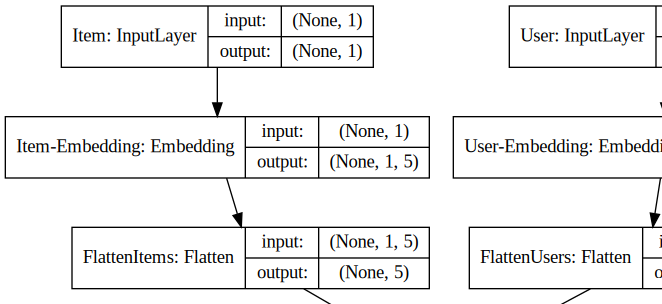

In [32]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 5)         25605       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         210725      User[0][0]                       
____________________________________________________________________________________________

In [36]:
%%time
history = model.fit([train.SessionId, train.ItemId], train.ActionScore, epochs=1, verbose=5)

Epoch 1/1
CPU times: user 2min 24s, sys: 29.2 s, total: 2min 53s
Wall time: 47.1 s


In [37]:
y_hat = np.round(model.predict([test.SessionId, test.ItemId]),0)
y_true = test.ActionScore

In [39]:
mean_absolute_error(y_true, y_hat)

0.6012973467715329

### Extract Embedding

In [40]:
item_embedding_learnt = model.get_layer(name='Item-Embedding').get_weights()[0]
pd.DataFrame(item_embedding_learnt).describe()

,0,1,2,3,4
count,5121.000000,5121.000000,5121.000000,5121.000000,5121.000000
mean,-0.323681,0.681971,0.640228,-0.224153,0.245083
std,0.677532,0.672881,0.642586,0.684204,0.722002
min,-3.536342,-1.968172,-1.976570,-3.742739,-3.746885
25%,-0.774506,0.251230,0.228214,-0.652796,-0.275193
50%,-0.416180,0.696539,0.647818,-0.190742,0.198691
75%,0.009828,1.127578,1.069184,0.204774,0.728775
max,3.562541,3.831408,4.227465,2.656243,3.194803


In [41]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2,3,4
count,42145.000000,42145.000000,42145.000000,42145.000000,42145.000000
mean,-0.074906,0.218798,0.202947,-0.079795,0.090513
std,0.230619,0.187996,0.185901,0.215069,0.223809
min,-0.903614,-1.099777,-0.971521,-0.994897,-1.033591
25%,-0.248700,0.146134,0.124057,-0.225326,-0.045484
50%,-0.077931,0.243874,0.229840,-0.114697,0.133332
75%,0.092304,0.331819,0.319617,0.047467,0.245095
max,0.930646,1.431247,1.237424,0.954440,1.044126


### Non-negative Matrix Factorization

In [43]:
item_input = keras.layers.Input(shape=[1],name='Item')
item_embedding = keras.layers.Embedding(n_items + 1, n_latent_factors, name='NonNegItem-Embedding', 
                                        embeddings_constraint=non_neg())(item_input)
item_vec = keras.layers.Flatten(name='FlattenItems')(item_embedding)

In [44]:
user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,
                                name='NonNegUser-Embedding', embeddings_constraint=non_neg())(user_input))

In [46]:
prod = keras.layers.dot([item_vec, user_vec], axes=1,name='DotProduct')
model = keras.Model([user_input, item_input], prod)
model.compile('adam', 'mean_squared_error')

In [48]:
%%time
history_nonneg = model.fit([train.SessionId, train.ItemId], train.ActionScore, epochs=1, verbose=2)

Epoch 1/1
 - 63s - loss: 2.0106
CPU times: user 3min 1s, sys: 33.7 s, total: 3min 35s
Wall time: 1min 3s


### Deep Learning

In [59]:
n_latent_factors_user = 5
n_latent_factors_items = 5

item_input = keras.layers.Input(shape=[1],name='Item')
item_embedding = keras.layers.Embedding(n_items + 1, n_latent_factors_items, name='Item-Embedding')(item_input)
item_vec = keras.layers.Flatten(name='FlattenItems')(item_embedding)
item_vec = keras.layers.Dropout(rate=0.2)(item_vec)

In [60]:
user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(rate=0.2)(user_vec)

In [62]:
concat = keras.layers.dot([item_vec, user_vec], axes=1,name='Concat')
concat_dropout = keras.layers.Dropout(rate=0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(rate=0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(rate=0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(rate=0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

In [63]:
result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)

In [64]:
model = keras.Model([user_input, item_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

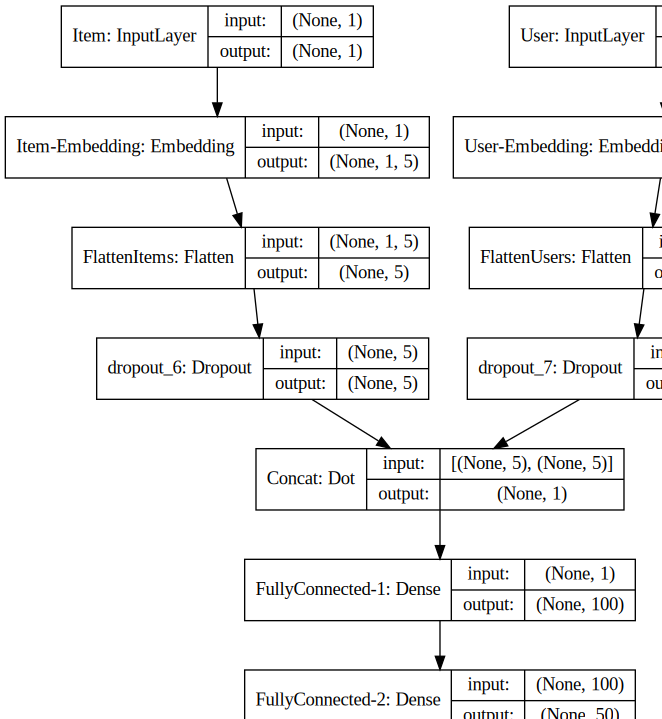

In [65]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [66]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 5)         25605       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         210725      User[0][0]                       
____________________________________________________________________________________________

In [71]:
%%time
history = model.fit([train.SessionId, train.ItemId], train.ActionScore, epochs=5, verbose=1)

Epoch 1/5
876967/876967 [==============================] - 62s 71us/step - loss: 0.5352
Epoch 2/5
876967/876967 [==============================] - 63s 72us/step - loss: 0.5344
Epoch 3/5
876967/876967 [==============================] - 64s 73us/step - loss: 0.5340
Epoch 4/5
876967/876967 [==============================] - 62s 70us/step - loss: 0.5339
Epoch 5/5
876967/876967 [==============================] - 64s 72us/step - loss: 0.5339
CPU times: user 15min 40s, sys: 3min 7s, total: 18min 47s
Wall time: 5min 14s


In [72]:
y_hat_2 = np.round(model.predict([test.SessionId, test.ItemId]),0)
print(mean_absolute_error(y_true, y_hat_2))

0.5305392662913336


In [73]:
print(mean_absolute_error(y_true, model.predict([test.SessionId, test.ItemId])))

0.5309141199023261
